In [1]:
import keras as k
import keras.layers as l
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import utils
import skimage.transform
from sklearn.metrics import roc_auc_score, roc_curve

Using TensorFlow backend.


The area under the curve of the receiver operating characteristic is the metric used to evaluate the model's accuracy as it trains. It gives a good idea of how well the model is doing over both the 1 and 0 labels.

In [2]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    k.backend.get_session().run(tf.local_variables_initializer())
    return auc

k.metrics.auc = auc #so model loading works

The labeled data of a certain patient is loaded, and standard scaled. Before it is fed into the networks, resizing the data so it has a shape of (2400,16) seems to be a sweet spot between quick evaluation time and high accuracy.

In [3]:
import os
from sklearn.preprocessing import StandardScaler
data = []
labels = []
patient = "2"
for filename in os.listdir("resized/"):
    if not filename.startswith("Pat"+patient+"Train"):
        continue
        
    downscaled = np.load("resized/"+filename) # this is predownscaled data
    #data = skimage.transform.resize(data,(2400, 16),anti_aliasing=True)
    st = StandardScaler()
    data.append(st.fit_transform(downscaled))
    without_extension = os.path.splitext(filename)[0]
    labels.append(without_extension[-1] == '1')

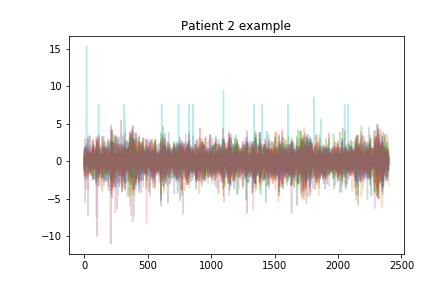

In [4]:
plt.plot(data[0],alpha=0.3)
plt.title("Patient "+patient + " example")
plt.show()

The data is randomly permuted so that we can cross validate unbiasedly.

In [5]:
label_array = np.reshape(np.array(labels, dtype=bool),(-1,1))
data_arr = np.array(data)
idx = np.array(range(0,data_arr.shape[0]))
np.random.shuffle(idx)
X = data_arr[idx]
_, sequence_length, nb_features = X.shape
y = label_array[idx]
labels_filter = label_array.ravel().copy()
print(data_arr.shape, label_array.shape)

(2058, 2400, 16) (2058, 1)


We split the data into train and test. Test being the cross validation data.

In [6]:
test_size = 200


train = np.array(range(X.shape[0]-test_size))
test = np.array(range(X.shape[0]-test_size, X.shape[0]))

train1_y = y[train][labels_filter[train]]
train0_y = y[train][~labels_filter[train]]
test1_y = y[test][labels_filter[test]]
test0_y = y[test][~labels_filter[test]]


train1_X = X[train][labels_filter[train]]
train0_X = X[train][~labels_filter[train]]

test1_X = X[test][labels_filter[test]]
test0_X = X[test][~labels_filter[test]]

print(train1_X.shape)
print(test1_X.shape)
print(train0_X.shape)
print(test0_X.shape)

(199, 2400, 16)
(23, 2400, 16)
(1659, 2400, 16)
(177, 2400, 16)


LSTM network generator with all the layers of specified unit sized returning sequences except the last one.

In [7]:
def lstm_creator(reg = 1e-6, layers = [20,10], dropout = 0.2):
    model = k.Sequential()
    for i in range(len(layers)):
        last_layer = i == len(layers)-1
        model.add(l.LSTM(
           input_shape          = (sequence_length, nb_features),
           units                = layers[i],
           return_sequences     = not last_layer,
           kernel_regularizer   = k.regularizers.l2(reg),
           activity_regularizer = k.regularizers.l1(reg)))
        model.add(l.Dropout(dropout))

    model.add(l.Dense(units=1, activation='sigmoid',kernel_regularizer=k.regularizers.l2(reg),
                    activity_regularizer=k.regularizers.l1(reg)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auc])
    return model


CNN network generator with exponentially decreasing kernel size, linearly increasing number of filters and a final layer without max pooling.

In [8]:
def cnn_creator(reg = 2e-4, dropout = 0.5, num_layers=3):
    model = k.Sequential()
    for i in reversed(range(num_layers)):
        kernel_size = 5*(2**i)
        filters = 10*(num_layers-i)
        model.add(l.Conv1D(
            filters = filters,
            kernel_size = kernel_size,
            kernel_regularizer=k.regularizers.l2(reg),
            input_shape = (sequence_length, nb_features),
            activation='relu'))
        model.add(l.Dropout(rate = dropout))
        if i > 0:
            model.add(l.MaxPooling1D(pool_size = 2))
            
    model.add(l.GlobalAveragePooling1D())

    model.add(l.Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auc])
    return model

The fastest running and converging neural network is just the default cnn generated by the previous method fitted for 20 epochs

In [9]:
model = cnn_creator()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2381, 10)          3210      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2381, 10)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1190, 10)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1181, 20)          2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1181, 20)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 590, 20)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 586, 30)           3030      
__________

Model weights can be set so that if you change some parameters after training, the learned parameters can be reused

In [10]:
#model.set_weights(currweights)

In [11]:
model.fit(X[train], y[train],batch_size=25,epochs=30)

Epoch 1/30
1858/1858 [==============================] - 8s 4ms/step - loss: 0.3986 - acc: 0.8681 - auc: 0.4669
Epoch 2/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3619 - acc: 0.8940 - auc: 0.4559
Epoch 3/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3603 - acc: 0.8940 - auc: 0.4671
Epoch 4/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3542 - acc: 0.8940 - auc: 0.4813
Epoch 5/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3516 - acc: 0.8940 - auc: 0.4950
Epoch 6/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3517 - acc: 0.8940 - auc: 0.5019
Epoch 7/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3455 - acc: 0.8940 - auc: 0.5136
Epoch 8/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3344 - acc: 0.8940 - auc: 0.5259
Epoch 9/30
1858/1858 [==============================] - 6s 3ms/step - loss: 0.3272 - acc: 0.8940 - auc: 0.5419
E

ROC curve and different accuracy checks for train and test data so we can measure bias and variance easily

In [12]:
def evaluate_model(model):
    xs,ys,ts = roc_curve(y[test],model.predict_proba(X[test]))
    plt.plot(xs,ys)
    xs,ys,ts = roc_curve(y[train],model.predict_proba(X[train]))
    plt.plot(xs,ys)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['Training roc','Cross validation roc'])
    plt.show()
    print('AUC(train) = ' + str(roc_auc_score(y[train], model.predict_proba(X[train]))))
    print('AUC(test)  = ' + str(roc_auc_score(y[test], model.predict_proba(X[test]))))
    acc1train = model.evaluate(train1_X,train1_y,verbose=False)[1]
    print('train 1 accuracy = ' + str(acc1train))
    acc0train = model.evaluate(train0_X,train0_y,verbose=False)[1]
    print('train 0 accuracy = ' + str(acc0train))
    acc1test = model.evaluate(test1_X,test1_y,verbose=False)[1]
    print('test 1 accuracy  = ' + str(acc1test))
    acc0test = model.evaluate(test0_X,test0_y,verbose=False)[1]
    print('test 0 accuracy  = ' + str(acc0test))

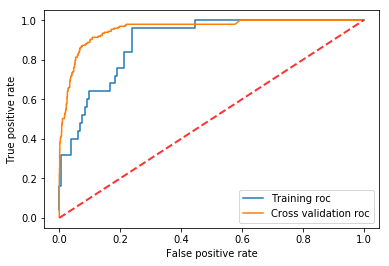

AUC(train) = 0.9574838715592405
AUC(test)  = 0.8916571428571428
train 1 accuracy = 0.924623116176931
train 0 accuracy = 0.9342977694893113
test 1 accuracy  = 0.8695651888847351
test 0 accuracy  = 0.9152542379616344


In [13]:
evaluate_model(model)

Here we set the model weights that were learned to be reused if needed

In [14]:
currweights = model.get_weights()

In [15]:
#model.save('cnn_pat3_classifier_mini.h5')

A grid search over the hyperparameters to get the best performing nn on this cross validation data.

In [16]:
def tune_hypers():
    max_model = 0
    max_roc = 0
    max_reg = 0
    max_dropout = -1
    results = []
    for reg in [1e-5,1e-4,1e-3,5e-3,1e-2]:
        for dropout in [0.5,0.6,0.7,0.8,0.9,0.95]:
            new_model = lstm_creator(reg, dropout)
            new_model.set_weights(new_weights)
            new_model.fit(X[train], y[train],batch_size=25,epochs=5)
            new_roc = roc_auc_score(y[test], new_model.predict_proba(X[test]))
            train_roc = roc_auc_score(y[train], new_model.predict_proba(X[train]))
            print(new_roc)
            results.append((new_roc,train_roc, reg, dropout))
            if(new_roc > max_roc):
                max_roc = new_roc
                max_model = new_model
                max_reg = reg
                max_dropout = dropout
    return (max_model,max_roc,max_reg,max_dropout,results)